#### copyright: Ford Motor Company 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

In [14]:
import pandas as pd
import numpy as np

In [34]:
df_tmp = pd.read_csv('C:/Projects/FCSD/FNOP/old/Traindata_pilot_sample_v0.csv', engine='python')

In [35]:
df_1 = df_tmp[['cust_txt', 'target']]

In [36]:
### create count by target df
target_count_df = df_1.groupby('target')['cust_txt'].count().to_frame(name='row_count').reset_index()

In [7]:
### load the model
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [15]:
sentences_df = pd.read_csv("C:/Projects/FCSD/FNOP/old/revised_processed_cust_txt_for_gensim.csv")

In [18]:
sentence_embeddings = model(sentences_df['process_txt'])

### use clustering algorithm to find similar cust_txt

In [21]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing
from sklearn import metrics

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [23]:
def find_optimal_clusters(data, init_k, max_k, step_k):
    iters = range(init_k, max_k+1, step_k)
    
    sse = []
    for k in iters:
        ### The inertia is defined as the sum of square distances of samples to their nearest neighbor.
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 10 clusters
Fit 20 clusters
Fit 30 clusters
Fit 40 clusters
Fit 50 clusters
Fit 60 clusters
Fit 70 clusters
Fit 80 clusters
Fit 90 clusters
Fit 100 clusters


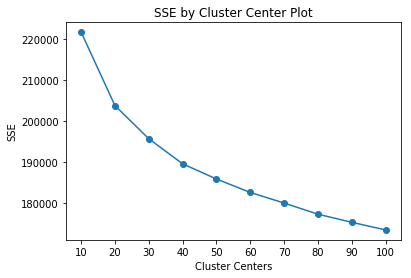

In [27]:
find_optimal_clusters(sentence_embeddings, 10, 100, 10)

Fit 70 clusters
Fit 72 clusters
Fit 74 clusters
Fit 76 clusters
Fit 78 clusters
Fit 80 clusters
Fit 82 clusters
Fit 84 clusters
Fit 86 clusters
Fit 88 clusters
Fit 90 clusters
Fit 92 clusters
Fit 94 clusters
Fit 96 clusters
Fit 98 clusters
Fit 100 clusters


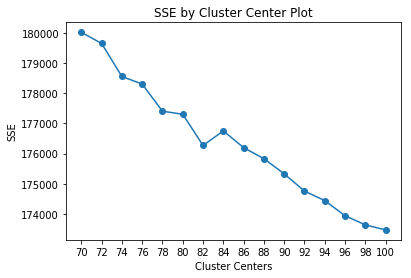

In [28]:
find_optimal_clusters(sentence_embeddings, 70, 100, 2)

Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters
Fit 52 clusters
Fit 54 clusters
Fit 56 clusters
Fit 58 clusters
Fit 60 clusters
Fit 62 clusters
Fit 64 clusters
Fit 66 clusters
Fit 68 clusters
Fit 70 clusters


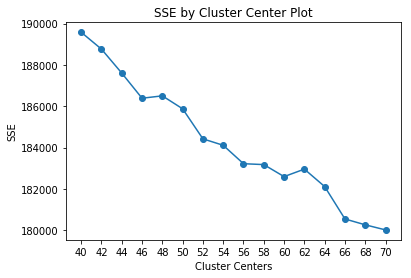

In [46]:
find_optimal_clusters(sentence_embeddings, 40, 70, 2)

In [29]:
kmeans_78 = MiniBatchKMeans(n_clusters=78, init_size=1024, batch_size=2048, random_state=20).fit(sentence_embeddings)
cluster_assign = kmeans_78.labels_

In [30]:
clusters_google = kmeans_78.fit_predict(sentence_embeddings)

In [31]:
clusters_google[:30]

array([15, 44, 77, 23, 34, 49, 77, 77, 38, 77, 34, 49, 63, 77, 77, 27, 77,
       49, 33, 77, 33, 27, 77, 23, 23, 68, 24, 77, 23, 23])

In [32]:
sil_score_78 = metrics.silhouette_score(sentence_embeddings, cluster_assign, metric = 'euclidean')

In [33]:
sil_score_78

0.044783723

In [37]:
cluster_assign_df = pd.DataFrame(cluster_assign, columns = ['cluster_id'])

In [38]:
cluster_compare_df = pd.concat([df_1[['target']], cluster_assign_df], axis = 1)

In [41]:
cluster_compare_df.groupby('cluster_id')['target'].count().to_frame(name='row_count').sort_values('row_count', ascending=False)

row_count
cluster_id           
7               12012
24               8353
8                7779
3                7734
45               7455
...               ...
54               1838
75               1782
32               1535
30               1110
56                498

[78 rows x 1 columns]

In [42]:
cluster_name_list = list(set(clusters_google))

In [43]:
cluster_analysis_df = pd.DataFrame()
for c in cluster_name_list:
    cluster_target_count_df = cluster_compare_df.loc[lambda df: df['cluster_id']==c, ].groupby('target')['cluster_id'].count().to_frame(name='row_count').reset_index()
    merged_target_count_df = target_count_df.merge(cluster_target_count_df, 'left', on='target').fillna(0)
    merged_target_count_df['cluster_ratio']=merged_target_count_df['row_count_y']/merged_target_count_df['row_count_x']
    top_1_per_cluster = merged_target_count_df.sort_values('cluster_ratio', ascending=False).iloc[:1,:]
    top_1_per_cluster['cluster_id'] = c
    cluster_analysis_df = pd.concat([cluster_analysis_df, top_1_per_cluster], ignore_index=True)

In [44]:
cluster_analysis_df.to_csv("C:/Projects/FCSD/FNOP/old/sentence_encoder_78_clusters_top1.csv", index=False)

In [45]:
cluster_compare_df.loc[lambda df: df['target']=='10346',].groupby('cluster_id')['target'].count().to_frame(name='row_count').sort_values('row_count', ascending=False)

row_count
cluster_id           
77               2122
49                431
63                332
38                206
68                169
...               ...
52                  1
12                  1
8                   1
7                   1
37                  1

[61 rows x 1 columns]

### try with 46 clusters

In [47]:
kmeans_46 = MiniBatchKMeans(n_clusters=46, init_size=1024, batch_size=2048, random_state=20).fit(sentence_embeddings)
cluster_assign = kmeans_46.labels_

In [48]:
cluster_assign_df = pd.DataFrame(cluster_assign, columns = ['cluster_id'])

In [49]:
cluster_compare_df = pd.concat([df_1[['target']], cluster_assign_df], axis = 1)

In [50]:
cluster_compare_df.groupby('cluster_id')['target'].count().to_frame(name='row_count').sort_values('row_count', ascending=False)

row_count
cluster_id           
36              13233
2               13060
30              11898
35              11770
23              11643
6               10802
44              10445
29              10419
3               10349
25              10308
12              10152
10              10076
41               9831
16               9830
8                9449
15               9192
18               8810
5                8663
33               8208
21               8181
43               7860
42               7844
1                7601
37               7473
9                7465
17               7427
0                7372
11               7128
26               6867
32               6782
40               6679
14               6428
39               6384
20               6201
28               5955
22               5666
4                5441
19               4989
7                4608
38               4443
24               4339
31               4175
27               3603
45               3226
34               3134
13               2591

In [51]:
cluster_compare_df.loc[lambda df: df['target']=='10346',].groupby('cluster_id')['target'].count().to_frame(name='row_count').sort_values('row_count', ascending=False)

row_count
cluster_id           
27               2333
39                475
24                340
17                232
2                 203
38                151
40                145
21                117
11                 93
30                 93
18                 70
3                  67
12                 61
45                 56
25                 55
8                  52
32                 49
28                 47
34                 32
1                  27
26                 23
29                 18
13                 13
10                 13
4                   9
36                  8
35                  5
20                  4
23                  4
44                  4
33                  3
19                  3
14                  2
37                  2
6                   2
5                   2
7                   1
9                   1
15                  1
22                  1

In [53]:
clusters_google = kmeans_46.fit_predict(sentence_embeddings)

In [54]:
clusters_google[:30]

array([32,  3, 27, 17, 45, 24, 27, 27,  2, 27, 38, 24, 27, 27, 27, 24, 27,
       24,  3, 27,  3, 39, 27, 27, 40, 39, 12, 27, 40, 17])

In [55]:
sil_score_46 = metrics.silhouette_score(sentence_embeddings, cluster_assign, metric = 'euclidean')

In [56]:
sil_score_46

0.048658494